In [15]:
from pathlib import Path
import random
import os

In [6]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)


In [7]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [8]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

==> /Users/keke/workspace/machine-learning-best-practice/机器学习/transformer/DATA/rawdata/ted2020/train_dev.raw.en <==
Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because I need that.
Put yourselves in my position.
I flew on Air Force Two for eight years.
Now I have to take off my shoes or boots to get on an airplane!
I'll tell you one quick story to illustrate what that's been like for me.
It's a true story -- every bit of this is true.
Soon after Tipper and I left the -- White House -- we were driving from our home in Nashville to a little farm we have 50 miles east of Nashville.
head: -n: No such file or directory
head: 5: No such file or directory
==> /Users/keke/workspace/machine-learning-best-practice/机器学习/transformer/DATA/r

In [9]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [10]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

/Users/keke/workspace/machine-learning-best-practice/机器学习/transformer/DATA/rawdata/ted2020/train_dev.raw.clean.en & zh exists. skipping clean.
==> /Users/keke/workspace/machine-learning-best-practice/机器学习/transformer/DATA/rawdata/ted2020/train_dev.raw.clean.en <==
Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
I flew on Air Force Two for eight years .
Now I have to take off my shoes or boots to get on an airplane !
I'll tell you one quick story to illustrate what that's been like for me .
It's a true story every bit of this is true .
Soon after Tipper and I left the White House we were driving from our home in Nashville to a little farm we have 50 miles east of Nashville

In [11]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [16]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

In [18]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /Users/keke/workspace/machine-learning-best-practice/机器学习/transformer/DATA/rawdata/ted2020/train.clean.en
  input: /Users/keke/workspace/machine-learning-best-practice/机器学习/transformer/DATA/rawdata/ted2020/valid.clean.en
  input: /Users/keke/workspace/machine-learning-best-practice/机器学习/transformer/DATA/rawdata/ted2020/train.clean.zh
  input: /Users/keke/workspace/machine-learning-best-practice/机器学习/transformer/DATA/rawdata/ted2020/valid.clean.zh
  input_format: 
  model_prefix: /Users/keke/workspace/machine-learning-best-practice/机器学习/transformer/DATA/rawdata/ted2020/spm8000
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 1000000
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sen

In [20]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

In [21]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

==> ./DATA/rawdata/ted2020/train.en <==
▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁opportunity ▁to ▁come ▁to ▁this ▁stage ▁ t wi ce ▁; ▁i ' m ▁extreme ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con f er ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁i ▁f le w ▁on ▁air ▁force ▁two ▁for ▁eight ▁years ▁.
▁now ▁i ▁have ▁to ▁take ▁off ▁my ▁sh o es ▁or ▁bo ot s ▁to ▁get ▁on ▁an ▁air pla ne ▁!
▁i ' ll ▁tell ▁you ▁one ▁ qui ck ▁story ▁to ▁i ll us tra te ▁what ▁that ' s ▁been ▁like ▁for ▁me ▁.
▁it ' s ▁a ▁true ▁story ▁every ▁bit ▁of ▁this ▁is ▁true ▁.
▁so on ▁after ▁ ti pp er ▁and ▁i ▁left ▁the ▁white ▁house ▁we ▁were ▁dr iv ing ▁from ▁our ▁home ▁in ▁na sh vi ll e ▁to ▁a ▁little ▁far m ▁we ▁have ▁ 50 ▁mil es ▁e as t ▁of ▁na sh 

In [27]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

2023-06-25 11:56:41 | INFO | fairseq_cli.preprocess | Namespace(no_progress_bar=False, log_interval=100, log_format=None, log_file=None, aim_repo=None, aim_run_hash=None, tensorboard_logdir=None, wandb_project=None, azureml_logging=False, seed=1, cpu=False, tpu=False, bf16=False, memory_efficient_bf16=False, fp16=False, memory_efficient_fp16=False, fp16_no_flatten_grads=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, on_cpu_convert_precision=False, min_loss_scale=0.0001, threshold_loss_scale=None, amp=False, amp_batch_retries=2, amp_init_scale=128, amp_scale_window=None, user_dir=None, empty_cache_freq=0, all_gather_list_size=16384, model_parallel_size=1, quantization_config_path=None, profile=False, reset_logging=False, suppress_crashes=False, use_plasma_view=False, plasma_path='/tmp/plasma', criterion='cross_entropy', tokenizer=None, bpe=None, optimizer=None, lr_scheduler='fixed', scoring='bleu', task='translation', source_lang='en', target_lang='zh', tr

In [29]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

In [30]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = src_lang,
    target_lang = tgt_lang,
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=15,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

In [31]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

In [32]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

AssertionError: Torch not compiled with CUDA enabled

In [33]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2023-06-25 12:05:09 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2023-06-25 12:05:09 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [34]:
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2023-06-25 12:05:27 | INFO | fairseq.data.data_utils | loaded 390,112 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2023-06-25 12:05:27 | INFO | fairseq.data.data_utils | loaded 390,112 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2023-06-25 12:05:27 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390112 examples
2023-06-25 12:05:27 | INFO | fairseq.data.data_utils | loaded 3,940 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2023-06-25 12:05:27 | INFO | fairseq.data.data_utils | loaded 3,940 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2023-06-25 12:05:27 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3940 examples


In [35]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  64,    9,  853,   79,  978,   63,   31, 1318,  106,  140,  536,    6,
          61,   20,    6,  265,  120,  652,    4,  217,   26,  141,   79,   27,
          17,    9,  141,   24,  420,   86,    6,   16,    9, 1487,   85,    4,
         996,    9,    5,   54,   23,   79,  106,   14,  350,  700,   11,    9,
         247,  893,    6,   18, 1138,    9,  117,   42,   15,    6,    5,  723,
         227,  209,   13,  383,    6,    7,    2]),
 'target': tensor([ 114,    5,  275,  237,  115,    5,  796,  166, 2285,  289,  670, 3057,
         190,    8, 1879, 1582,  165, 1879, 1582,  127,  211,  864, 1180,    8,
         766,  400,   77, 3305, 1168,  205,  461, 2532, 2122, 1146,  734,  249,
        1620, 1738, 1386,  105, 3259,  342,   36, 1186, 3875,    8, 3135, 3793,
        1392,    2])}
('Source: what the actor does with this information depends on its policy , '
 'which is stored in the strengths of the connection , between the odor '
 "detectors and the mo

In [53]:
seed=33
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=200, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['net_input']['src_tokens'],
        config.post_process,
    )
)
pprint.pprint(
    "pre_output_tokens: " + \
    task.target_dictionary.string(
        sample['net_input']['prev_output_tokens'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

("Source: <pad><pad><pad><pad> as humans , we've sort of extended the concept "
 'of disgust to morality .\n'
 '<pad><pad><pad><pad> i know that for a fact . so , tell us these stories and '
 'inspire others on the website .\n'
 '<pad><pad><pad><pad> for me , like millions of other people around the world '
 'today , english is an acquired language .\n'
 '<pad><pad><pad><pad> on the fifth rung , we develop conclusions based on our '
 'assumptions .\n'
 '<pad><pad><pad><pad> it had a greater population of sheep than people , so '
 'help if we needed it was nowhere to be found .\n'
 '<pad><pad><pad><pad> these two new airplanes are the same speed as the dc8 '
 'that was done in 1958 .\n'
 '<pad><pad><pad><pad> i trained in classical ballet and have a background in '
 'architecture and fashion .')
('pre_output_tokens: 人類有點將厭惡的概念擴展至道德 '
 '。<pad><pad><pad><pad><pad><pad><pad><pad><pad>\n'
 '所以 , 在網站上告訴我們這些故事並啟發其他的人 。<pad><pad><pad><pad><pad><pad><pad><pad>\n'
 '對我而言 , 以及全世界幾百萬人一樣英文是第二語言<pad

In [54]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

In [55]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # pass thru bidirectional RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # Since Encoder is bidirectional, we need to concatenate the hidden states of two directions
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

In [56]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

In [65]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # extract the outputs from encoder
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # if the information from last timestep is retained, we can continue from there instead of starting from bos
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # incremental state does not exist, either this is training time, or the first timestep of test time
            # prepare for seq2seq: pass the encoder_hidden to the decoder hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # pass thru unidirectional RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # project to embedding size (if hidden differs from embed size, and share_embedding is True, 
        # we need to do an extra projection)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # project to vocab size
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # if incremental, record the hidden states of current timestep, which will be restored in the next timestep
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

In [57]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

In [58]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

In [96]:
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary # 源词典、目标词典

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
    decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)
    # encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    # decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

In [66]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=512,
    encoder_layers=1,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=1,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

# add_transformer_args(arch_args)

In [97]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

model = build_model(arch_args, task)

aaaaaa <fairseq.data.dictionary.Dictionary object at 0x7f7d0b5c2a70>


In [68]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

In [69]:
def get_rate(d_model, step_num, warmup_step):
    # TODO: Change lr from constant to the equation shown above
    lr = 0.001
    return lr

In [70]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

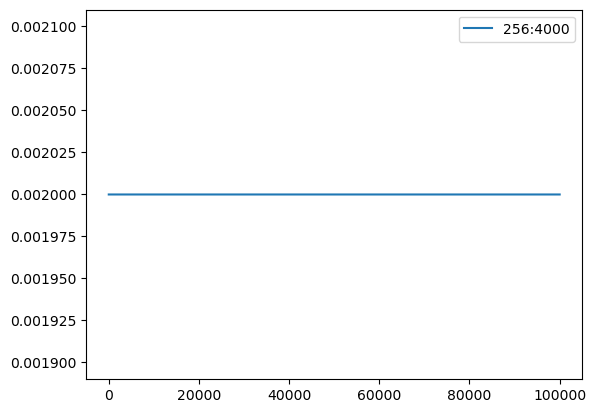

In [71]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

In [98]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

In [77]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [104]:
epoch_itr = load_data_iterator(task, "train", epoch=1, max_tokens=100, num_workers=1,cached=False)

src_dict, tgt_dict = task.source_dictionary, task.target_dictionary


encoder_embed_tokens = nn.Embedding(len(src_dict), arch_args.encoder_embed_dim, src_dict.pad())
decoder_embed_tokens = nn.Embedding(len(tgt_dict), arch_args.decoder_embed_dim, src_dict.pad())
print(encoder_embed_tokens)
# train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)

2023-06-25 15:03:29 | WARNING | fairseq.tasks.fairseq_task | 4,494 samples have invalid sizes and will be skipped, max_positions=(100, 100), first few sample ids=[88322, 88281, 88209, 76048, 90969, 90787, 88313, 88318, 88259, 90941]


Embedding(8000, 256, padding_idx=1)


In [113]:
max_len=100
d_model=256
position = np.arange(100)[:, np.newaxis]
pe = np.zeros((max_len, d_model))
div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
pe[:, 0::2] = np.sin(position * div_term)

pe

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.41470985e-01,  0.00000000e+00,  8.01961795e-01, ...,
         0.00000000e+00,  1.07460783e-04,  0.00000000e+00],
       [ 9.09297427e-01,  0.00000000e+00,  9.58144376e-01, ...,
         0.00000000e+00,  2.14921564e-04,  0.00000000e+00],
       ...,
       [ 3.79607739e-01,  0.00000000e+00,  7.45109484e-01, ...,
         0.00000000e+00,  1.04235072e-02,  0.00000000e+00],
       [-5.73381872e-01,  0.00000000e+00, -8.97521193e-02, ...,
         0.00000000e+00,  1.05309621e-02,  0.00000000e+00],
       [-9.99206834e-01,  0.00000000e+00, -8.52340887e-01, ...,
         0.00000000e+00,  1.06384168e-02,  0.00000000e+00]])

In [114]:
class RNNDecoder(FairseqIncrementDecoder):
    def __init__():
        self.dropout_in_module = nn.Dropout(args.dropout)

        self.rnn = nn.GRU(
            self.embed_dim,
            self.hidden_dim,
            self.num_layers,
            dropout=args.dropout,
            batch_first=False,
            bidirectional=False,
        )

        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        )

        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)

        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out

        if incremental_state is not None and len(incremental_state) > 0:
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state= self.get_incremental_state(incremental_state, 'cached_state')
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            prev_hiddens = encoder_hiddens

        bsz, seqlen = prev_output_tokens.size()

        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        x = x.transpose(0,1)

        if self.attention is not None:
            x, attn = self.attention((x, encoder_outputs, encoder_padding_mask)

            x, final_hiddens = self.rnn(x, prev_hiddens)

            x = self.dropout_out_module(x)

        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        x = self.output_projection(x)

        x = x.transpose(1,0)

        cache_state = {
            "prev_hiddens": final_hiddens
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)

        return x, None


NameError: name 'FairseqIncrementDecoder' is not defined

In [ ]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
            self,
            src_tokens,
            src_lengths,
            prev_output_tokens,
            return_all_hiddens: bool = True
    ):
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )

        logits, extra = src.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens
        )

        return logits, extra

In [115]:
from fairseq.models.transformer import (
    TransformerEncoder,
    TransformerDecoder,
)

def build_model(args, task):
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    encoder_embed_tokens = nn.Embedding(len(Src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())


    # encoder decoder
    encoder = RNNEncoder(args, src_dict, encoder_embed_tokens)
    decoder = RNNDecoder(args, tgt_dict, decoder_embed_tokens)

    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tat_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)

    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
            if isinstance(module, MultiheadAttention):
                module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
                module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
                module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.RNNBase):
                for name, param in module.named_parameters():
                    if "weight" in name or "bias" in name:
                        param.data.uniform_(-0.1, 0.1)
            if isinstance(module, nn.RNNBase):
                for name, param in module.named_parameters():
                    if "weight" in name or "bias" in name:
                        param.data.uniform_(-0.1, 0.1)
        
        module.apply(init_params)
        return model
    





In [ ]:
arch_args = Namespace(
    encoder_embed_dim=256
    encoder_ffn_embed_dim=512
    encoder_layers=1
    decoder_embed_dim=256
    decoder_layers=1
    share_decoder_input_output_embed=True
    dropout=0.3
)

def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True

    args.decoder_attention_heads=4
    args.decoder_normalize_before=True

    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024

    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

# add_transformer_args(arch_args)

In [116]:
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    
    for i in range(len(gen_out)):
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_di)
        ))

SyntaxError: invalid syntax (386835247.py, line 3)

In [ ]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

In [ ]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

In [ ]:
import sentencepiece as spm
import numpy as np
import gensim

# 1. 构建Unigram词汇表
corpus = ["This is the first sentence.", "This is the second sentence."]
spm.SentencePieceTrainer.Train('--input=corpus.txt --model_prefix=unigram_model --model_type=unigram')

# 2. 加载Unigram模型
unigram_model = spm.SentencePieceProcessor()
unigram_model.Load("unigram_model.model")

# 3. 构建Word Embedding模型
sentences = [unigram_model.EncodeAsPieces(sentence) for sentence in corpus]
embedding_model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=1, workers=4)

# 4. 获取单词向量
def get_word_vector(word):
    try:
        vector = embedding_model.wv[word]
    except KeyError:
        vector = np.zeros(100)  # 如果单词不在词汇表中，返回零向量
    return vector

# 5. 示例输入单词
input_word = "sentence"

# 6. 获取单词向量
word_vector = get_word_vector(input_word)

# 7. 打印结果
print("Word:", input_word)
print("Word Vector:", word_vector)


In [150]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print()
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang { tgt_lang}\
        --trainpref {prefix/'train'}\
            

In [ ]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

In [ ]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

In [ ]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

In [ ]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

In [155]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # pass thru bidirectional RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # Since Encoder is bidirectional, we need to concatenate the hidden states of two directions
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

SyntaxError: positional argument follows keyword argument (624573949.py, line 7)

In [156]:
# 构建